In [1]:
import numpy as np

import lunar_lander
from turbo_test import demo_heuristic_lander
import tensorflow as tf
import tensorflow_probability as tfp
import trieste

import timeit

2021-12-03 15:18:38.111839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 15:18:38.111858: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-03 15:18:39.222151: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-03 15:18:39.244155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 15:18:39.244480: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.683GHz coreCount: 15 deviceMemorySize: 7.93GiB devi

In [2]:
# this space is created by going approximately +-0.2 around parameter values, but not going below 0
# see for original values https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py
# original values are
# 0.5 1 0.4 0.55 0.5 1 0.5 0.5 0 0.5 0.05 0.05
# and for parameter definition https://github.com/uber-research/TuRBO
search_space = trieste.space.Box(
    [0.3, 0.8, 0.2, 0.35, 0.3, 0.8, 0.3, 0.3, 0.0, 0.3, 0.0,  0.0],
    [0.7, 1.2, 0.6, 0.75, 0.7, 1.2, 0.7, 0.7, 0.2, 0.7, 0.25, 0.25]
)

# lander landed, minimize fuel
FUEL = "FUEL"
# minimize failures, when the lander crashes or times out
FAILURE = "FAILURE"

In [3]:
create_empty_dataset = lambda : trieste.data.Dataset(
                                    tf.zeros((0, search_space.dimension), tf.float64),
                                    tf.zeros((0, 1), tf.float64)
                                )

def lander_observer(x):
    all_datasets = {
        FUEL: create_empty_dataset(),
        FAILURE: create_empty_dataset()
    }

    def add_data(dataset_tag, x, y):
        new_dataset = trieste.data.Dataset(np.atleast_2d(x), np.atleast_2d(y))
        all_datasets[dataset_tag] += new_dataset

    for w in x.numpy():
        result = demo_heuristic_lander(lunar_lander.LunarLander(), w)
        # that's different from constrained optimization
        # because now we want to minimize failure
        # and not penalize by it
        # thus we flip the 1 and 0 values in this dataset
        if result.timeout or result.has_crashed:
            add_data(FAILURE, w, 1.0)
            continue
        else:
            add_data(FAILURE, w, 0.0)

        normalized_fuel = np.float64(result.total_fuel / 100.0)
        add_data(FUEL, w, normalized_fuel)
    
    return all_datasets

In [4]:
num_initial_points = 1
initial_query_points = search_space.sample(1)
initial_data = lander_observer(initial_query_points)

# collect points until we have at least one in each dataset
while any(len(initial_data[tag]) < search_space.dimension for tag in initial_data):
    initial_query_points = search_space.sample(1)
    new_initial_data = lander_observer(initial_query_points)
    for tag in initial_data:
        initial_data[tag] = initial_data[tag] + new_initial_data[tag]
    num_initial_points += 1


print(len(initial_data[FUEL]))
print(len(initial_data[FAILURE]))


DemoHeuristicResult: reward: -12.62, fuel: 10.71, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -87.42, fuel: 166.95, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 238.72, fuel: 23.34, steps: 266.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -17.19, fuel: 13.80, steps: 106.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 40.95, fuel: 14.01, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 39.30, fuel: 15.48, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -27.73, fuel: 9.72, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -0.66, fuel: 17.91, steps: 103.0, crashed: True, timeou

In [9]:
import gpflow


def create_regression_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance, lengthscales=[0.2]*int(search_space.dimension))
    scale = tf.constant(1.0, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.constant(-2.0, dtype=tf.float64), scale
    )
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), scale
    )
    gpr = gpflow.models.GPR(data.astuple(), kernel)
    return gpr


def create_classification_model(data):
    kernel = gpflow.kernels.SquaredExponential(
        lengthscales=[0.2]*int(search_space.dimension)
    )
    likelihood = gpflow.likelihoods.Bernoulli()
    vgp = gpflow.models.VGP(data.astuple(), kernel, likelihood)
    return vgp

from trieste.models.gpflow import GPflowModelConfig

classification_model_config_args = {
    "model_args": {"use_natgrads": True},
    "optimizer": tf.optimizers.Adam(1e-3),
    "optimizer_args": {"max_iter": 50},
}
models = {
    FUEL: GPflowModelConfig(**{
        "model": create_regression_model(initial_data[FUEL]),
        "optimizer": gpflow.optimizers.Scipy(),
    }),
    FAILURE: GPflowModelConfig(
        create_classification_model(initial_data[FAILURE]),
        **classification_model_config_args
    )
}

In [6]:
# class SpecialModelStack(trieste.models.ModelStack):
#     """ Special treatment of predict_joint used in sampler
#     """
#     def __init__(self, models_dict):
#         super().__init__((models_dict[FUEL], 1), (models_dict[FAILURE], 1))
#         self._models_dict = models_dict

#     def predict(self, query_points):
#         fuel_mean, fuel_var = self._models_dict[FUEL].predict(query_points)
#         failure_mean, failure_var = self._models_dict[FAILURE].predict_y(query_points)
#         return tf.concat([fuel_mean, failure_mean], axis=-1), tf.concat([fuel_var, failure_var], axis=-1)


class SpecialSampler(trieste.acquisition.sampler.IndependentReparametrizationSampler):
    def sample(self, at, jitter=0.0):
        sample = super().sample(at, jitter)

        fuel_part = sample[:, :, :, 0]
        failure_part = sample[:, :, :, 1]
        
        failure_part = self._model._models[1]._model.likelihood.invlink(failure_part)
        
        sample = tf.stack([fuel_part, failure_part], axis=-1)
        
        return sample


class SpecialBatchMonteCarloExpectedHypervolumeImprovement(trieste.acquisition.function.AcquisitionFunctionBuilder):
    """ The one in trieste is single model, and we need to pass two models and two datasets
    """

    def __init__(self, sample_size: int, *, jitter: float = trieste.utils.misc.DEFAULTS.JITTER):
        """
        :param sample_size: The number of samples from model predicted distribution for
            each batch of points.
        :param jitter: The size of the jitter to use when stabilising the Cholesky decomposition of
            the covariance matrix.
        :raise ValueError (or InvalidArgumentError): If ``sample_size`` is not positive, or
            ``jitter`` is negative.
        """
        tf.debugging.assert_positive(sample_size)
        tf.debugging.assert_greater_equal(jitter, 0.0)

        super().__init__()

        self._sample_size = sample_size
        self._jitter = jitter

    def __repr__(self) -> str:
        """"""
        return (
            f"SpecialBatchMonteCarloExpectedHypervolumeImprovement({self._sample_size!r},"
            f" jitter={self._jitter!r})"
        )

    def prepare_acquisition_function(
        self,
        models,
        datasets,
    ):
        # failure dataset will have all points
        # while fuel only successful ones
        query_points = datasets[FAILURE].query_points
        
        # [0] is because we only need mean and not variance
        means = tf.concat([models[FUEL].predict(query_points)[0], models[FAILURE].predict_y(query_points)[0]], axis=-1)
        _pf = trieste.acquisition.multi_objective.pareto.Pareto(means)
        _reference_pt = trieste.acquisition.multi_objective.pareto.get_reference_point(_pf.front)
        # prepare the partitioned bounds of non-dominated region for calculating of the
        # hypervolume improvement in this area
        _partition_bounds = trieste.acquisition.multi_objective.partition.prepare_default_non_dominated_partition_bounds(_reference_pt, _pf.front)

        models = [(models[FUEL], 1), (models[FAILURE], 1)]
        sampler = SpecialSampler(self._sample_size, trieste.models.interfaces.ModelStack(*models))

        return trieste.acquisition.function.batch_ehvi(sampler, self._jitter, _partition_bounds)

In [10]:
from trieste.acquisition.rule import EfficientGlobalOptimization

BATCH_SIZE = 1
ITERATIONS = 30

mc_ehvi = SpecialBatchMonteCarloExpectedHypervolumeImprovement(sample_size=5)
rule = EfficientGlobalOptimization(mc_ehvi, num_query_points=BATCH_SIZE)


bo = trieste.bayesian_optimizer.BayesianOptimizer(lander_observer, search_space)
start = timeit.default_timer()
result = bo.optimize(ITERATIONS, initial_data, models, rule).final_result.unwrap()
stop = timeit.default_timer()

DemoHeuristicResult: reward: 243.45, fuel: 36.66, steps: 379.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -223.61, fuel: 69.36, steps: 668.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 68.96, fuel: 30.15, steps: 186.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 67.27, fuel: 162.93, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -98.00, fuel: 157.02, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 145.88, fuel: 78.90, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 36.13, fuel: 104.55, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 55.71, fuel: 145.53, steps: 1001.0, crashed:

In [11]:
import matplotlib.pyplot as plt

# fancy code to import trieste notebook plotting utils
import importlib.util
spec = importlib.util.spec_from_file_location("plotting", "../docs/notebooks/util/plotting.py")
plotting = importlib.util.module_from_spec(spec)
spec.loader.exec_module(plotting)

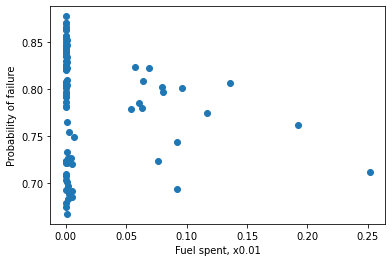

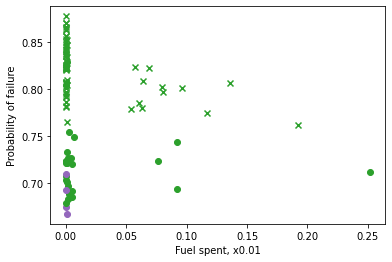

In [12]:
all_query_points = result.datasets[FAILURE].query_points
objective_model_values, _ = result.models[FUEL].predict(all_query_points)
failure_model_values, _ = result.models[FAILURE].predict_y(all_query_points)

plt.scatter(objective_model_values, failure_model_values);
plt.xlabel("Fuel spent, x0.01");
plt.ylabel("Probability of failure");
plt.show();

points_in_objective_space = tf.concat([objective_model_values, failure_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points)
plt.xlabel("Fuel spent, x0.01");
plt.ylabel("Probability of failure");
plt.show();

In [13]:
result.models[FUEL]._model.kernel.lengthscales

<Parameter: dtype=float64, shape=[12], fn="softplus", numpy=
array([0.07486973, 0.07421553, 0.07425151, 0.07451937, 0.07491842,
       0.07442627, 0.0749561 , 0.07451472, 0.07373795, 0.07424941,
       0.07421946, 0.07380003])>

In [14]:
result.models[FAILURE]._model.kernel.lengthscales

<Parameter: dtype=float64, shape=[12], fn="softplus", numpy=
array([0.52189341, 0.55681554, 0.55805813, 0.55106645, 0.62265023,
       0.58089477, 0.55234606, 0.52440568, 0.59481161, 0.56967911,
       0.52027617, 0.49786021])>

In [15]:
result.models[FAILURE]._model

name,class,transform,prior,trainable,shape,dtype,value
VGPWrapper.kernel.variance,Parameter,Softplus,,True,(),float64,0.4733071321286626
VGPWrapper.kernel.lengthscales,Parameter,Softplus,,True,"(12,)",float64,"[0.52189341, 0.55681554, 0.55805813..."
VGPWrapper.data[0],ResourceVariable,,,False,"(None, 12)",float64,"[[0.31436195, 1.03873589, 0.46777948..."
VGPWrapper.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[1....
VGPWrapper.q_mu,Parameter,Identity,,True,"(93, 1)",float64,[[1.37757666...
VGPWrapper.q_sqrt,Parameter,FillTriangular,,True,"(1, 93, 93)",float64,"[[[6.18239746e-01, 0.00000000e+00, 0.00000000e+00..."
VGPWrapper._num_data,ResourceVariable,,,False,(),float64,93.0


In [16]:
def probability_of_failure(point, n_tries=100):
    if not isinstance(point, np.ndarray):
        point = point.numpy()

    assert point.shape == (int(search_space.dimension),)

    n_failures = 0
    for _ in range(n_tries):
        result = demo_heuristic_lander(lunar_lander.LunarLander(), point, print_result=False)
        if result.timeout or result.has_crashed:
            n_failures += 1
    
    return n_failures / n_tries

In [17]:
from trieste.acquisition.multi_objective.dominance import non_dominated

pf_points, _ = non_dominated(tf.concat([objective_model_values, failure_model_values], axis=1))
pf_input_points = []
for pf_point in pf_points:
    pf_input_point = tf.boolean_mask(all_query_points, tf.equal(objective_model_values, pf_point[0])[:,0])
    if len(pf_input_point) > 1:
        pf_input_point = pf_input_point[0:1, :]
    pf_input_points.append(pf_input_point)
pf_input_points = tf.concat(pf_input_points, axis=0)

In [18]:
failure_actual_values = [probability_of_failure(p) for p in pf_input_points]

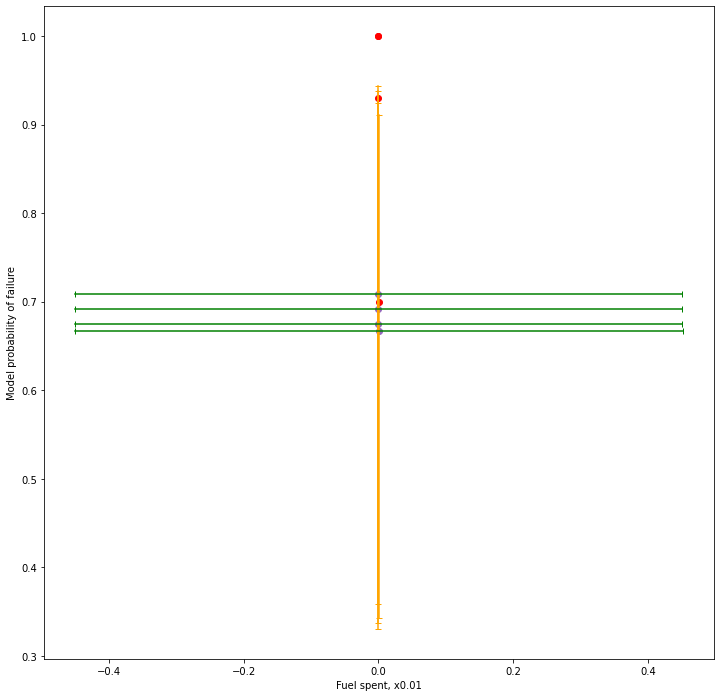

In [19]:
points_in_objective_space = tf.concat([objective_model_values, failure_model_values], axis=1)

mean, variance = result.models[FAILURE].predict(pf_input_points)
failure_lower_conf_bounds = result.models[FAILURE]._model.likelihood.invlink(mean - 2 * tf.sqrt(variance))
failure_upper_conf_bounds = result.models[FAILURE]._model.likelihood.invlink(mean + 2 * tf.sqrt(variance))

mean, variance = result.models[FUEL].predict(pf_input_points)
objective_lower_conf_bounds = mean - 2 * tf.sqrt(variance)
objective_upper_conf_bounds = mean + 2 * tf.sqrt(variance)

plotting.plot_mobo_points_in_obj_space(
    points_in_objective_space,
    num_init=num_initial_points,
    only_plot_pareto=True,
    figsize=(12,12)
)
plt.scatter(pf_points[:, 0], failure_actual_values, c='r')

for i, (lower, upper) in enumerate(zip(failure_lower_conf_bounds, failure_upper_conf_bounds)):
    plt.plot((pf_points[i].numpy()[0], pf_points[i].numpy()[0]), (lower,upper), '_-',color='orange')

for i, (lower, upper) in enumerate(zip(objective_lower_conf_bounds, objective_upper_conf_bounds)):
    plt.plot((lower,upper), (pf_points[i].numpy()[1], pf_points[i].numpy()[1]), '|-',color='green')


plt.xlabel("Fuel spent, x0.01")
plt.ylabel("Model probability of failure");
plt.show();